# Import Packages

In [1]:
import sys
import os

#PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'
#sys.path.append(PATH_with_functions)
PATH_save0 = ''
PATH_read0 = ''
PATH_save = ''
PATH_save2 = ''

import glob
import xarray as xr
import numpy as np
import pandas as pd

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import scipy.interpolate as spi
import scipy.integrate as spint
from scipy.ndimage import gaussian_filter, correlate
from scipy.signal import hilbert,hilbert2,fftconvolve

from functions_cfosat_env import *
from surface_simulation_functions import *
from altimetry_waveforms_functions import *
from matplotlib.dates import DateFormatter
# --- plotting and interactive stuff ----------------------
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator, FixedLocator

#from Envelope_convolution_functions import *

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

cmap0 = 'viridis'

# Prepare all

In [2]:
# ------ plot retrack vs 4 * std(zeta) for all radiuses for both ind1 and ind2 -------------
def custom_plots_surf(ax,im,iskm=1,alongT_isY=1,labelcb=None):
    if alongT_isY:
        xlb = 'Cross-track '
        ylb = 'Along-track '
    else:
        xlb = 'X '
        ylb = 'Y '

    if iskm:
        xlb = xlb+'[km]'
        ylb = ylb+'[km]'
    else:
        xlb = xlb+'[m]'
        ylb = ylb+'[m]'       
    
    ax.set_xlabel(xlb);
    ax.set_ylabel(ylb);

    ax.set_aspect('equal', 'box');
    if labelcb is None:
        plt.colorbar(im, ax=ax)
    else:
        plt.colorbar(im, ax=ax,label=labelcb)
    return ax

def custom_plots_spec(ax,im,iswnb=1,alongT_isY=1,klim=None,labelcb=None):
    if iswnb:
        xlb = '$k_x$ [rad/m]'
        ylb = '$k_x$ [rad/m]'
    else:
        xlb = '$k_x / 2 \pi$ [km$^{-1}$]'
        ylb = '$k_y / 2 \pi$ [km$^{-1}$]'
    
    if alongT_isY:
        ax.set_xlabel(ylb)
        ax.set_ylabel(xlb)
    else:
        ax.set_xlabel(xlb)
        ax.set_ylabel(ylb)

    ax.set_aspect('equal', 'box');
    if labelcb is None:
        plt.colorbar(im, ax=ax)
    else:
        plt.colorbar(im, ax=ax,label=labelcb)
        
    if klim is not None:
        ax.set_xlim((-klim,klim))
        ax.set_ylim((-klim,klim))
    return ax

## Read spectrum

In [4]:
DS = xr.open_dataset(PATH_save2+'Spectrum_L2S_ind9_35.nc')
Hs_9 = DS['Hs_ind_9_box'].compute().data
Hs_9_L2S = DS['Hs_ind_9_L2S'].compute().data
Hs_35 = DS['Hs_ind_35_box'].compute().data
Hs_35_L2S = DS['Hs_ind_35_L2S'].compute().data
# Use factor to check different wave heights ... 
Hsfac=1
Lc_9 = calc_footprint_diam(Hs_9,529000)
print('ind 1: 9, Hs=',Hs_9,'m, Diameter Chelton =',Lc_9)
Lc_35 = calc_footprint_diam(Hs_35*Hsfac,529000)
print('ind 2: 35, Hs=',Hs_35,'m, Diameter Chelton =',Lc_35)



ind 1: 9, Hs= 9.315999984741211 m, Diameter Chelton = 6434.8806953936455
ind 2: 35, Hs= 9.303999900817871 m, Diameter Chelton = 6430.933463252923


## Generate or load sea surface (geometry only)

Surface: 9.290539952299259 42.87557718193585


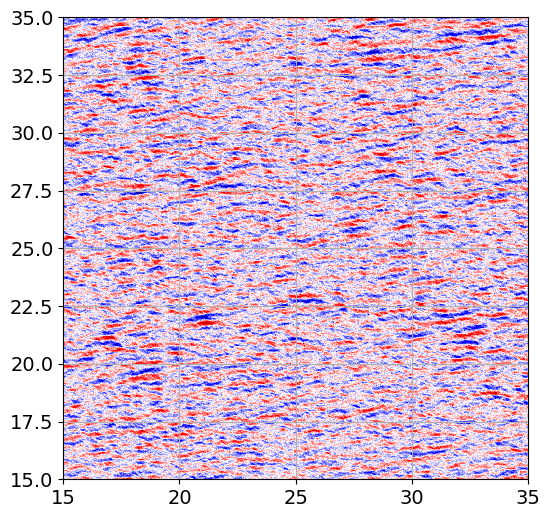

In [5]:
iscompute = 1
#Hs=Hs_9;Hs_L2S=Hs_9_L2S;Efth = DS['Spec_L2S_ind_9_1Sided'].compute().data*Hs**2/Hs_L2S**2*Hsfac**2
#th_vec = DS['phi_vector_L2S_ind_9'].compute().data
Hs=Hs_35;Hs_L2S=Hs_35_L2S;Efth = DS['Spec_L2S_ind_35_1Sided'].compute().data*Hs**2/Hs_L2S**2*Hsfac**2
th_vec = DS['phi_vector_L2S_ind_35'].compute().data
f_vec = DS['k_vector'].compute().data
nx = 2**12
ny = nx-2
dx=14
dy=14
seed=0
if iscompute:

    S_r,S_i,Xa,Ya,rg,kX2,kY2,Ekxky,dkx2,dky2,Hskk,Qkk=surface_from_Efth(Efth,f_vec,f_vec*0,th_vec,0.,
                                                               seed=seed,nx=nx,
                                                               ny=ny,dx=dx,dy=dy,iswvnb=1)

#    np.savez(PATH_save2+'surface_good_for_images_ind9_L2S',seed=seed,dx=dx,dy=dy,X=Xa,Y=Ya,S_r =S_r,S_i = S_i,Hskk=Hskk,Qkk=Qkk)
    np.savez(PATH_save2+'surface_good_for_images_ind35_L2S',seed=seed,dx=dx,dy=dy,X=Xa,Y=Ya,S_r =S_r,S_i = S_i,Hskk=Hskk,Qkk=Qkk)
else:
    data = np.load(PATH_save2+'surface_good_for_images_ind35_L2S.npz',allow_pickle=True)
    for k in data.keys():
        print(k+' = data["'+k+'"]')
        exec(k+' = data["'+k+'"]')
    Xa = X
    Ya = Y
    
fig,ax=plt.subplots(figsize=(6,6))
im=ax.pcolormesh(Xa/1000.,Ya/1000.,S_r,cmap='seismic')
_=ax.set_ylim((15,35))
_=ax.set_xlim((15,35))
print('Surface:',4*np.sqrt(np.var(S_r.flatten())),Qkk) 



B = np.sqrt(S_r**2+S_i**2)
nx = len(Xa)
ny = len(Ya)
Xa_cent = Xa - 0.5*Xa.max()
Ya_cent = Ya - 0.5*Ya.max()

## Define geometry of altimeter footprints

Chelton footprint diameter in pixel :  454  in km: 6.369859587107929
Maximum range used for retracking: 95
Number of range gates: 128
Gamma: 0.0005623754455581152 0.027925268031909273
Generating waveform 0  out of  106  ------------ 
Generating waveform 1  out of  106  ------------ 
Generating waveform 2  out of  106  ------------ 
Generating waveform 3  out of  106  ------------ 
Generating waveform 4  out of  106  ------------ 
Generating waveform 5  out of  106  ------------ 
Generating waveform 6  out of  106  ------------ 
Generating waveform 7  out of  106  ------------ 
Generating waveform 8  out of  106  ------------ 
Generating waveform 9  out of  106  ------------ 
Generating waveform 10  out of  106  ------------ 
Generating waveform 11  out of  106  ------------ 
Generating waveform 12  out of  106  ------------ 
Generating waveform 13  out of  106  ------------ 
Generating waveform 14  out of  106  ------------ 
Generating waveform 15  out of  106  ------------ 
Generating

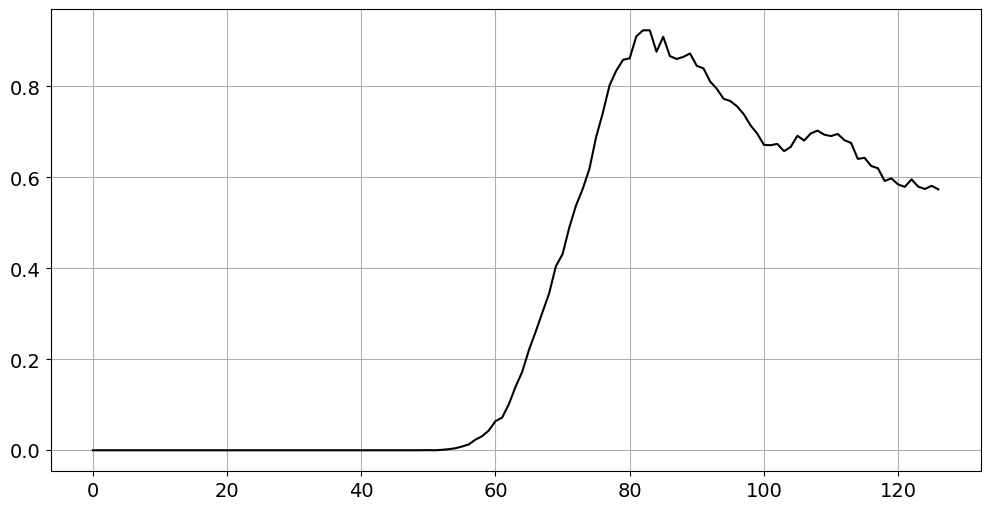

In [7]:
clight = 299792458
Rearth = 6378.1363*(10**3)      #Earth radius
v_sat = 7*1e3 # satellite velocity in m/s

Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.
ialti = 0

theta3dB=theta3dBs[ialti]
Gamma = 0.5 * (1.0/np.log(2.0))*np.sin(theta3dB)*np.sin(theta3dB)
alti_sat  = Altis[ialti]

#theta3dB=1.;
HRFAC=1
Gamma = 0.5 * (1.0/np.log(2.0))*np.sin(theta3dB)*np.sin(theta3dB)

bandwidth = BW[ialti]*HRFAC
bandx     = BX[ialti]*HRFAC     # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
nameSat   = namesAltis[ialti]
tau=1E9/bandwidth
tax=1E9/bandx

freq_satsampl = 20 # freq for waveforms


nx_s = np.min((len(Xa),len(Ya)))

di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)

# --- radius to compute waveforms --------------
DiamChelton = calc_footprint_diam(Hs,Rorbit = alti_sat)
nxa = np.floor(DiamChelton/dx).astype(int) # size of diameter of footprint in pixel
print('Chelton footprint diameter in pixel : ',nxa,' in km:',DiamChelton*0.001)
 
nxa0=np.floor(10*1e3/dx).astype(int) # shift to avoid boundary

nsamp=np.floor((nx_s-2*nxa0)/di).astype(int) # Nb of samplesnxa_L2 = np.floor(10*1e3/dx_c).astype(int)
#nsamp=5

dr = clight * 1/(2*bandwidth)
radi0 = nxa*dx   # 
nominal_tracking_gate=70
range_offset = nominal_tracking_gate*dr  # number of meters above nadir sea level included in waveform

ranges = np.arange(0,128*HRFAC*dr,dr)    # remember to increase 35 to higher values if needed
rlim = np.sqrt((radi0/2)**2+(alti_sat)**2)-alti_sat+range_offset
max_range_fit=np.argmax(ranges[ranges<=rlim])
print('Maximum range used for retracking:',max_range_fit)

print('Number of range gates:',len(ranges))

#Gamma=1
print('Gamma:',Gamma,theta3dB)
Earth_sphericity_coeff = 1. # (1+alti_sat/Rearth)
iscompute = 1
if iscompute:
    Xalt, Yalt, waveforms1 = simu_waveform_erf(Xa,Ya,S_r,nsamp,nsamp-1,nxa0,nxa,\
                                  di,ranges,range_offset=range_offset,alti_sat=alti_sat,\
                                  Gamma=Gamma,Earth_sphericity_coeff=Earth_sphericity_coeff)
    waveforms=waveforms1
    #print(np.shape(waveforms1))
    np.savez(PATH_save0+'waveforms_128p_brown_flat_'+nameSat,alti_sat = alti_sat,name_sat = nameSat,BWs = bandwidth,
             Xalt = Xalt,Yalt = Yalt,waveforms = waveforms)
else:
    data=np.load(PATH_read0+'waveforms_128p_brown_flat_'+nameSat+'.npz',allow_pickle=True)
    #waveforms1=data.waveforms
    for k in data.keys():
        print(k+' = data["'+k+'"]')
        exec(k+' = data["'+k+'"]')
        

fig,ax=plt.subplots(figsize=(12,6))
line1=ax.plot(waveforms[0,0,:],color='k',label='waveform')
wv0=waveforms


### Adds noise and PTR

211.2 3.125 2.5


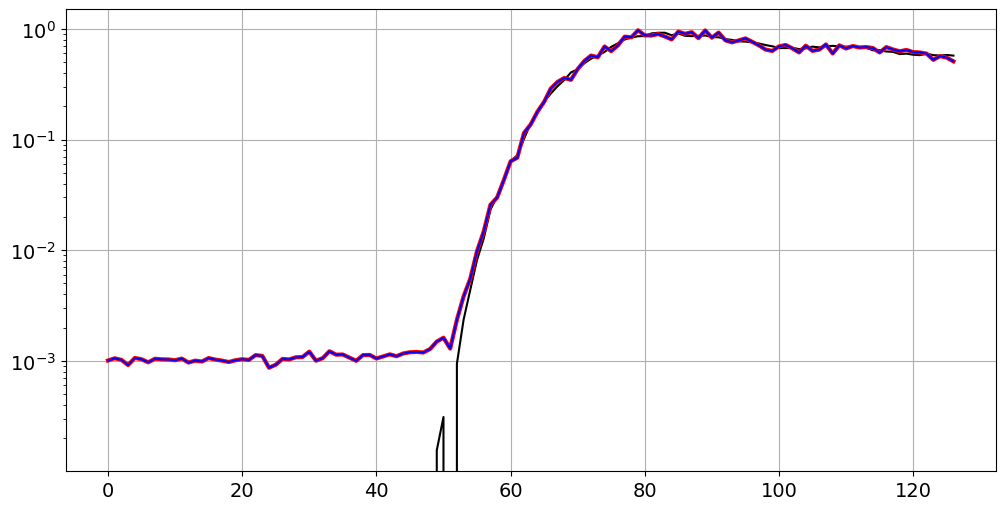

In [8]:
Ns=264.0*tau/tax 
print(Ns,tax,tau)
[n1,n2,n3]=np.shape(waveforms)
rng = np.random.default_rng(0)
rng2 = np.random.default_rng(1)
eps=rng.normal(0,1,(n1,n2,n3))/np.sqrt(Ns)
eps2=rng2.normal(0,1,(n1,n2,n3))/np.sqrt(Ns)
noise=0.001
#print('SIze:',n1,n2,n3,ranges,'#',127*dr,dr)
stonano=1000000000
rtot=(2./clight)*stonano  #Converts range to time
times=ranges*rtot
nr2=int(n3/2)
t0=tau*(nr2)
PTR=(np.sinc(np.pi*(times-t0)/tax))**2
s=sum(PTR)
PTR=PTR.T/s
#PTR=[1]
noisetag='speckle'
from scipy.signal import fftconvolve
wv1=wv0*(1+eps)+ noise*(1+eps2)
#noisetag='nonoise';wv1=wv0
wv2=wv1
for ix in range(n1):
    for iy in range(n2):
        ff0=wv1[ix,iy,:]
        fff =fftconvolve(ff0,PTR,mode='same')
        wv2[ix,iy,:]=fff

waveforms=wv2

fig,ax=plt.subplots(figsize=(12,6))
line1=ax.plot(wv0[0,0,:],color='k',label='waveform')
line2=ax.plot(wv1[0,0,:],color='r',label='waveform',linewidth=3)
line3=ax.plot(waveforms[0,0,:],color='b',label='waveform')
ax.set_yscale('log')

In [9]:
wf_model='wf_brown'
max_range_fit=nominal_tracking_gate+50*HRFAC    # SMALL DR
min_range_fit=nominal_tracking_gate-10*HRFAC    # SMALL DR
min_range_fit=nominal_tracking_gate-30*HRFAC    # SMALL DR
misp2=[0.]
rat=0.06;rattag='rat0600';  # This is the parameter used for Figure 8. 

iscompute=1
if iscompute:
    # --- compute only retracking ---------------------------

    Hs1,ze1,Pu1,da1,R01,di1=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model=wf_model,costfun='ML',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=min_range_fit,min_gate_rat=rat)
    Hs2,ze2,Pu2,da2,R02,di2=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR,wf_model=wf_model,costfun='LS',\
                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=min_range_fit,min_gate_rat=0.06)

    np.savez(PATH_save0+'Hs_ze_retrack_3par_NMML_brown_ptr_flat_128_'+rattag+'_'+noisetag+'_'+nameSat,alti_sat = alti_sat,name_sat = nameSat,BWs = bandwidth,
             Xalt = Xalt,Yalt = Yalt,waveforms=waveforms, Hs_retrack = Hs1, ze = ze1, Pu=Pu1,dar=da1,R0r=R01)
    np.savez(PATH_save0+'Hs_ze_retrack_3par_NMLS_brown_ptr_flat_128_'+rattag+'_'+noisetag+'_'+nameSat,alti_sat = alti_sat,name_sat = nameSat,BWs = bandwidth,
             Xalt = Xalt,Yalt = Yalt,waveforms=waveforms,Hs_retrack = Hs2, ze = ze2, Pu=Pu2,dar=da2,R0r=R02)
else:
    data=np.load('Hs_ze_retrack_3par_NMLS_flat_128_'+rattag+'_'+noisetag+'_'+nameSat+'.npz',allow_pickle=True)
    for k in data.keys():
       print(k+' = data["'+k+'"]')
       exec(k+' = data["'+k+'"]')
    Hs2=Hs_retrack
    ze2=ze
    Pu2=Pu
    data=np.load('Hs_ze_retrack_3par_NMML_flat_128_'+rattag+'_'+noisetag+'_'+nameSat+'.npz',allow_pickle=True)
    for k in data.keys():
       print(k+' = data["'+k+'"]')
       exec(k+' = data["'+k+'"]')
    Hs1=Hs_retrack
    ze1=ze
    Pu1=Pu
    
#rat=0.0600;rattag='rat0600';
#Hs1,ze1,Pu1,da1,R01,di1=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
#                                    min_method='Nelder-Mead',PTR_model='True',PTR=[1],wf_model=wf_model,costfun='ML',\
#                                    alti_sat=alti_sat,mispointing=misp2,theta3dB=theta3dB,\
#                                    nominal_tracking_gate=nominal_tracking_gate,min_range_fit=min_range_fit,min_gate_rat=rat)
#np.savez(PATH_save0+'Hs_ze_retrack_3par_NMML_flat_128_'+rattag+'_'+noisetag+'_'+nameSat,alti_sat = alti_sat,name_sat = nameSat,BWs = bandwidth,
#             Xalt = Xalt,Yalt = Yalt,waveforms=waveforms, Hs_retrack = Hs1, ze = ze1, Pu=Pu1,dar=da1,R0r=R01)

size of waveforms array: 106 105 127 alti_sat: 519000.0
Estimated noise level: 0.0010005580494275332 175.0
Retracking waveforms 0  out of  106  ------------ 
Retracking waveforms 1  out of  106  ------------ 
Retracking waveforms 2  out of  106  ------------ 
Retracking waveforms 3  out of  106  ------------ 
Retracking waveforms 4  out of  106  ------------ 
Retracking waveforms 5  out of  106  ------------ 
Retracking waveforms 6  out of  106  ------------ 
Retracking waveforms 7  out of  106  ------------ 
Retracking waveforms 8  out of  106  ------------ 
Retracking waveforms 9  out of  106  ------------ 
Retracking waveforms 10  out of  106  ------------ 
Retracking waveforms 11  out of  106  ------------ 
Retracking waveforms 12  out of  106  ------------ 
Retracking waveforms 13  out of  106  ------------ 
Retracking waveforms 14  out of  106  ------------ 
Retracking waveforms 15  out of  106  ------------ 
Retracking waveforms 16  out of  106  ------------ 
Retracking waveform

### performs retracking 2D  (Hs, epoch)

In [10]:
print(np.round([np.std(Hs1),np.sqrt(np.mean(Hs1*Hs1)),np.mean(ze1),np.std(ze1)],2)) # np.std(Hs2),np.mean(Hs1),np.mean(Hs2)],2))
print(np.round([np.std(Hs2),np.sqrt(np.mean(Hs2*Hs2)),np.mean(ze2),np.std(ze2)],2)) # np.std(Hs2),np.mean(Hs1),np.mean(Hs2)],2))

print(noisetag+" & ML & %.2f &  %.2f & %.3f & %.2f \\\ " % (np.sqrt(np.mean(Hs1*Hs1)),np.std(Hs1) ,np.mean(ze1),np.std(ze1)) )
print("        & LS & %.2f &  %.2f & %.3f & %.2f \\\ " % (np.sqrt(np.mean(Hs2*Hs2)),np.std(Hs2) ,np.mean(ze2),np.std(ze2)) )


# was 1.3061399713512318 0.7042907386158322 7.631271627431747 9.20551908724639
#7.742241812059747 9.232421519306712

# with noise 
#1.0015186634022628 0.7530394525969349 8.823561089752591 9.207287643658915
#8.880217899226292 9.238030859996172

# just thermal 
#1.0006474138523174 0.7042912465026313 8.82402623499166 9.205513512603776
#8.880581863969862 9.23241599965204
# thermal 0.001
#0.9574570782119036 0.7027635750627168 9.077116745506306 9.243106425573421
#9.127473498628692 9.269783872179092


[ 0.8   9.23 -0.01  0.12]
[0.87 9.27 0.   0.11]
speckle & ML & 9.23 &  0.80 & -0.009 & 0.12 \\ 
        & LS & 9.27 &  0.87 & 0.003 & 0.11 \\ 


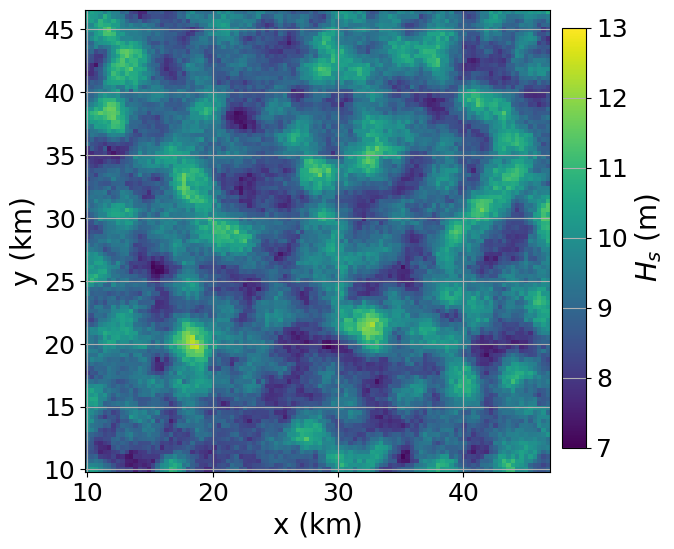

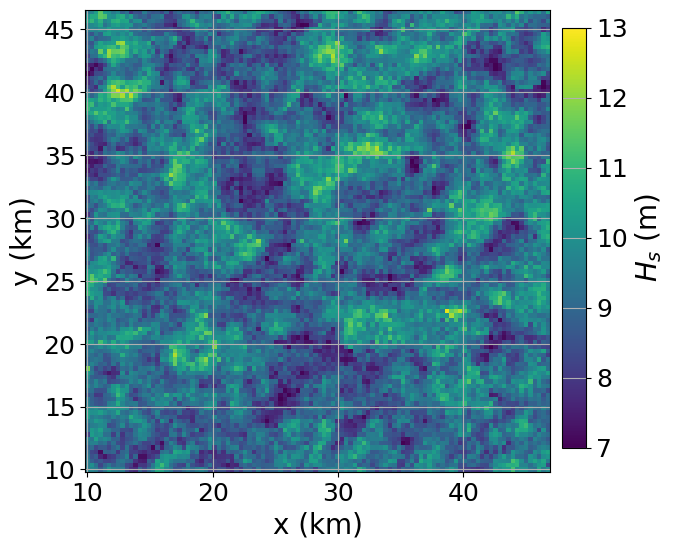

In [11]:
Hmin=7
Hmax=13
fig,ax=plt.subplots(figsize=(6,6))
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs1.T,vmin=Hmin, vmax=Hmax, rasterized=True)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label(r'$H_s$ (m)', fontsize=20)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig.savefig('Hs_map_3par_ML_'+rattag+'_'+noisetag+'.pdf')
fig.savefig('Hs_map_3par_ML_'+rattag+'_'+noisetag+'.png')

fig,ax=plt.subplots(figsize=(6,6))
#im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs2.T,vmin=4, vmax=14)
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs2.T,vmin=Hmin, vmax=Hmax, rasterized=True)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label(r'$H_s$ (m)', fontsize=20)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig.savefig('Hs_map_3par_LS_'+noisetag+'.pdf')
fig.savefig('Hs_map_3par_LS_'+noisetag+'.png')

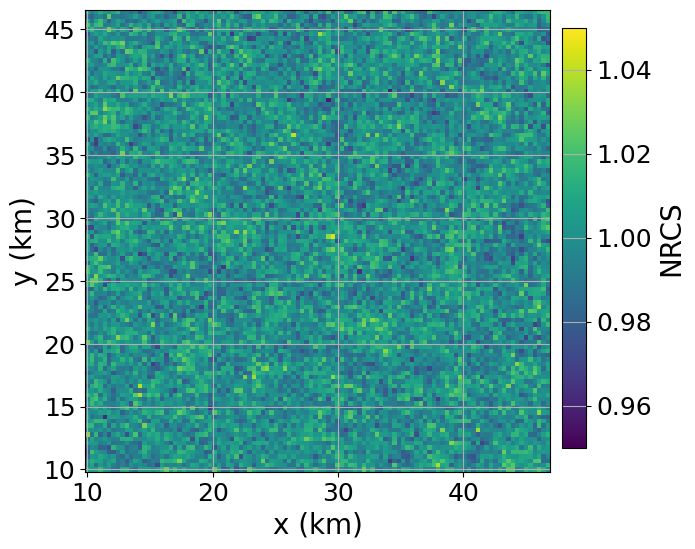

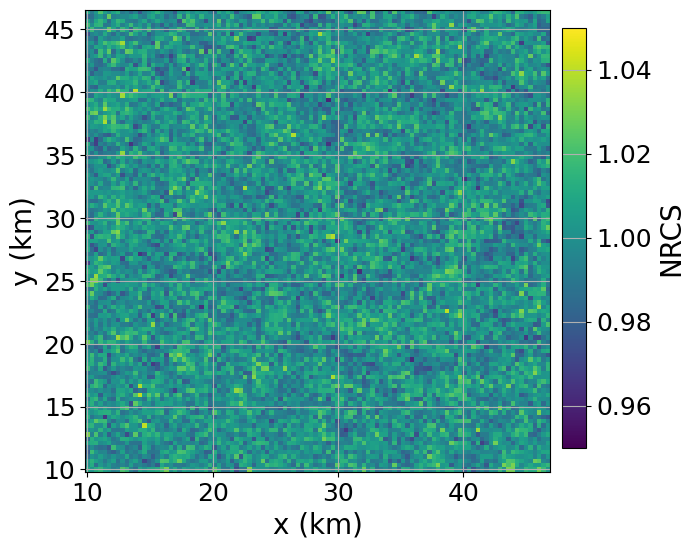

In [12]:
Hmin=0.95
Hmax=1.05
fig,ax=plt.subplots(figsize=(6,6))
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Pu1.T,vmin=Hmin, vmax=Hmax, rasterized=True)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label('NRCS', fontsize=20)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig.savefig('Pu_map_3par_ML_'+noisetag+'.pdf')
fig.savefig('Pu_map_3par_ML_'+noisetag+'.png')

fig,ax=plt.subplots(figsize=(6,6))
#im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs2.T,vmin=4, vmax=14)
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Pu2.T,vmin=Hmin, vmax=Hmax, rasterized=True)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label('NRCS', fontsize=20)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig.savefig('Pu_map_3par_LS_'+noisetag+'.pdf')
fig.savefig('Pu_map_3par_LS_'+noisetag+'.png')

In [13]:
def define_filter_annexA(Xa_c,Ya_c,DiamChelton,nkx_c,nky_c,dx_c,dy_c):
# Uses approximation r0**2/rc**2 = R0/Hs 
    twopi = 2*np.pi
    rc = DiamChelton/2
    [Xa_c2,Ya_c2] = np.meshgrid(Xa_c, Ya_c, indexing='ij')
 
    r0 = np.sqrt((Xa_c2)**2+(Ya_c2)**2)

# Defines a Gaussian filter scaled with rc 
    G_Lc20 = np.exp(-0.5* r0**2 / (rc)**2 )
    G_Lc2 = G_Lc20/(rc**2*twopi)

    Id = np.zeros(np.shape(G_Lc2))
    Id[nkx_c//2,nky_c//2]=1/(dx_c*dy_c)

#  This is the same as Jr0=  A*4/ (2*pi*h*Hs) * 0.5 * J = a/Delta *J/2
    Jr0 = (4*dx_c*dy_c/(np.pi*rc**2)) * (r0/rc)**2 * (6 - ((2*r0/rc)**4)) * np.exp(- 4 * r0**4 / rc**4)
#    Jr1 = fftconvolve((Id-G_Lc2),Jr0,mode='same')
#    Filter_new = (G_Lc2+Jr1)
    Jr1 = fftconvolve(Id,Jr0,mode='same')
    print('TEST:',np.shape(Jr0),np.sum(Jr0.flatten()),np.sum(Jr1.flatten()))
    
    Filter_new = (Jr1)
    
    phi_x0 = xr.DataArray(Filter_new,
        dims=['x','y'],
        coords={
            "x" : Xa_c,
            "y" : Ya_c,
            },
        )
    return phi_x0

#Functions (filter J2 + custom plots)
def define_filter_J2_annexA(Xa_c,Ya_c,DiamChelton,nkx_c,nky_c,dx_c,dy_c,isplot=0):
    twopi = 2*np.pi
    rc = DiamChelton/2
    [Xa_c2,Ya_c2] = np.meshgrid(Xa_c, Ya_c, indexing='ij')
    r0 = np.sqrt((Xa_c2)**2+(Ya_c2)**2)
# Defines a Gaussian filter scaled with rc 
    G_Lc20 = np.exp(-0.5* r0**2 / (rc)**2 )
    G_Lc2 = G_Lc20/(rc**2*twopi)
    Id = np.zeros(np.shape(G_Lc2))
    Id[nkx_c//2,nky_c//2]=1/(dx_c*dy_c)
#     plt.plot(Xa_c,Id[:,nky_c//2]-G_Lc2[:,nky_c//2])
# Uses approximation r0**2/rc**2 = R0/Hs 
#  This is the same as J200= -A / (4*2*pi*h*Hs) * J2
    J200 = (dx_c*dy_c/(4*np.pi*rc**2)) * (2 - 16*((r0/rc)**4)) * np.exp(- 4 * r0**4 / rc**4)
    #Jr2 = fftconvolve((Id-G_Lc2),J200,mode='same')
    Jr2 = fftconvolve((Id),J200,mode='same')
    print('TES2:',np.shape(Jr2),np.sum(J200.flatten()),np.sum(Jr2.flatten()))
    Filter_new = (Jr2)
    #print('Sum:',np.sum(np.abs(Filter_new)*dx_c*dy_c),dx_c*dy_c)
    #Filter_new = -Filter_new/np.sum(np.abs(Filter_new)*dx_c*dy_c)
    if isplot:
        plt.figure()
        plt.plot(Xa_c,G_Lc2[:,nky_c//2],label='G_{Lc}')
        plt.plot(Xa_c,J20[:,nky_c//2],label='J20')
        plt.plot(Xa_c,Jr2[:,nky_c//2],label='Jr2')
        plt.grid(True)
        plt.legend()
    phi_x0 = xr.DataArray(Filter_new,
                dims=['x','y'],
                coords={
                    "x" : Xa_c,
                    "y" : Ya_c,
                    },
                )
    return phi_x0

#Functions (filter J2 + custom plots)
def define_filter_G(Xa_c,Ya_c,DiamChelton,nkx_c,nky_c,dx_c,dy_c,isplot=0):
    twopi = 2*np.pi
    rc = DiamChelton/2
    [Xa_c2,Ya_c2] = np.meshgrid(Xa_c, Ya_c, indexing='ij')
    r0 = np.sqrt((Xa_c2)**2+(Ya_c2)**2)
# Defines a Gaussian filter scaled with rc 
    G_Lc20 = np.exp(-0.5* r0**2 / (rc)**2 )
    G_Lc2 = G_Lc20/(rc**2*twopi)
    Filter_new=(G_Lc2)
    if isplot:
        plt.figure()
        plt.plot(Xa_c,G_Lc2[:,nky_c//2],label='G_{Lc}')
        plt.plot(Xa_c,J20[:,nky_c//2],label='J20')
        plt.plot(Xa_c,Jr2[:,nky_c//2],label='Jr2')
        plt.grid(True)
        plt.legend()
    phi_x0 = xr.DataArray(Filter_new,
                dims=['x','y'],
                coords={
                    "x" : Xa_c,
                    "y" : Ya_c,
                    },
                )
    return phi_x0

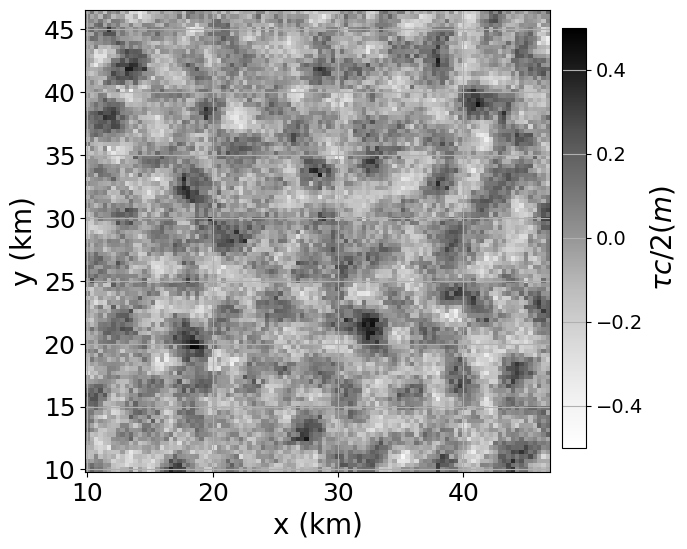

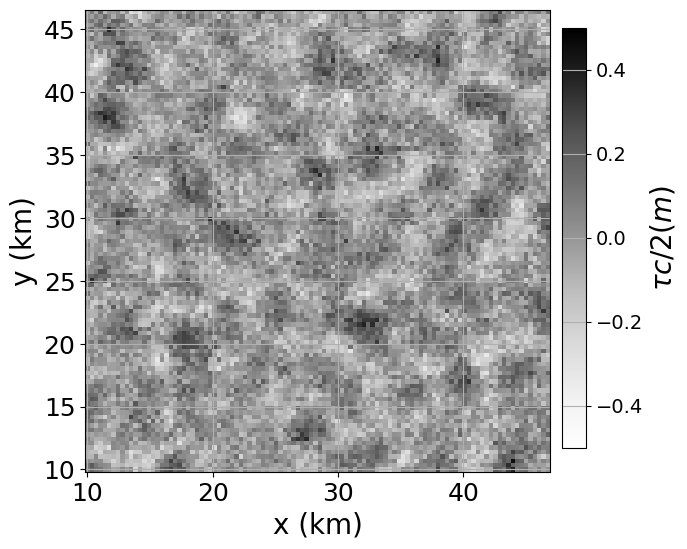

In [14]:
emin=-0.5
emax=0.5
fig,ax=plt.subplots(figsize=(6,6))
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,ze1.T,vmin=emin, vmax=emax, rasterized=True,cmap=plt.cm.Greys)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label(r'$\tau c/2 (m)$', fontsize=20)
ticklabs = cbar.ax.get_yticklabels()
#cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig.savefig('ze_map_3par_ML_'+noisetag+'.pdf')
fig.savefig('ze_map_3par_ML_'+noisetag+'.png')

fig,ax=plt.subplots(figsize=(6,6))
#im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs2.T,vmin=4, vmax=14)
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,ze2.T,vmin=emin, vmax=emax, rasterized=True,cmap=plt.cm.Greys)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label(r'$\tau c/2 (m)$', fontsize=20)
ticklabs = cbar.ax.get_yticklabels()
#cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig.savefig('ze_map_3par_LS_'+noisetag+'.pdf')
fig.savefig('ze_map_3par_LS_'+noisetag+'.png')

## Define filters to get (Hs,epoch) from envelope map

## Compute filters

In [15]:

Xa_cent = Xa - 0.5*Xa.max()
Ya_cent = Ya - 0.5*Ya.max()
print('Lc..:',Lc_35,di,di*dx,np.mean(ze2),Lc_35/4,Lc_35/5)
phi_J_AnnexA = define_filter_annexA(Xa_cent,Ya_cent,Lc_35,nx,ny,dx,dy)
phi_J2_A = define_filter_J2_annexA(Xa_cent,Ya_cent,Lc_35,nx,ny,dx,dy)
# Changed from 4.5 to 5
#phi_G1 = define_filter_G(Xa_cent,Ya_cent,Lc_35/4.5,nx,ny,dx,dy)
phi_G1 = define_filter_G(Xa_cent,Ya_cent,Lc_35/4,nx,ny,dx,dy)
phi_G2 = define_filter_G(Xa_cent,Ya_cent,di*dx,nx,ny,dx,dy)

Xaltc = Xalt - 0.5*Xalt.max()
Yaltc = Yalt - 0.5*Yalt.max()
phi_G3 = define_filter_G(Xaltc,Yaltc,Lc_35/4,106,105,dx*di,dy*di)
phi_G4 = define_filter_G(Xaltc,Yaltc,Lc_35/3,106,105,dx*di,dy*di)
print(np.shape(phi_G3))

Lc..: 6430.933463252923 25 350 0.002629407601756061 1607.7333658132306 1286.1866926505845
TEST: (4096, 4094) 1.0000000000000873 0.005102040816326973
TES2: (4096, 4094) 8.205491830208918e-18 3.209523515263784e-20
(106, 105)


## Apply filters

9.303999900817871 9.297350197672495 0.9992852855528522
(4094, 4096) (106, 105) (106,)


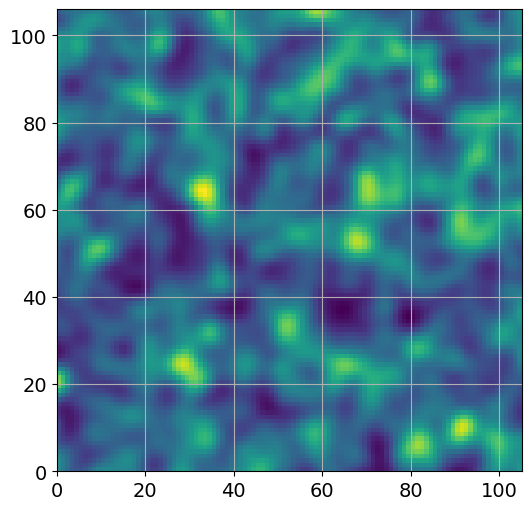

In [16]:

# coeff transforms the envelope to Hs map 
coeff=4*np.sqrt(2/np.pi)
iasamp = nxa0+np.arange(nsamp,dtype=int)*di

# -- fftconvolve J and J2 from Annex A to env ------
B11 = fftconvolve(B,phi_J_AnnexA,mode='same')*dx*dy
rat=np.mean(B.flatten())*coeff/Hs
print(Hs,np.mean(B.flatten())*coeff,rat)
B12 = B11[iasamp[:-1]][:,iasamp].T
equiv_Hs = coeff * B12/rat
print(np.shape(B),np.shape(B12),np.shape(iasamp))

B11 = fftconvolve(B,phi_G1,mode='same')*dx*dy
B22 = coeff *B11[iasamp[:-1]][:,iasamp].T
B11 = fftconvolve(B,phi_G2,mode='same')*dx*dy
B42 = coeff *B11[iasamp[:-1]][:,iasamp].T


B11 = fftconvolve(B,phi_J2_A,mode='same')*dx*dy
B32 = B11[iasamp[:-1]][:,iasamp].T
equiv_ze = coeff * B32/rat

fig,ax=plt.subplots(figsize=(6,6))
vmin=None
vmax=None
im=ax.pcolormesh(B22)

np.savez(PATH_save0+'Filtered_env_Lcover4',Xalt = Xalt,Yalt = Yalt,Hs_filt10=B22)

# PLOTS

LinregressResult(slope=np.float64(0.5826380197896207), intercept=np.float64(3.8426868182808107), rvalue=np.float64(0.7945960994690203), pvalue=np.float64(0.0), stderr=np.float64(0.004220185456652042), intercept_stderr=np.float64(0.039137794746189614))
Corr: PearsonRResult(statistic=np.float64(0.79459609946902), pvalue=np.float64(0.0))
Corr: PearsonRResult(statistic=np.float64(0.7071992087388148), pvalue=np.float64(0.0))
LinregressResult(slope=np.float64(0.4263443864346224), intercept=np.float64(-0.0016664616470083854), rvalue=np.float64(0.7071992087388147), pvalue=np.float64(0.0), stderr=np.float64(0.004040531044714704), intercept_stderr=np.float64(0.0004424370109101648))
LinregressResult(slope=np.float64(5.173592259689584), intercept=np.float64(9.240674105652886), rvalue=np.float64(0.7937866128670229), pvalue=np.float64(0.0), stderr=np.float64(0.03757713685984574), intercept_stderr=np.float64(0.004595665233555669))
LinregressResult(slope=np.float64(4.180718250574453), intercept=np.flo

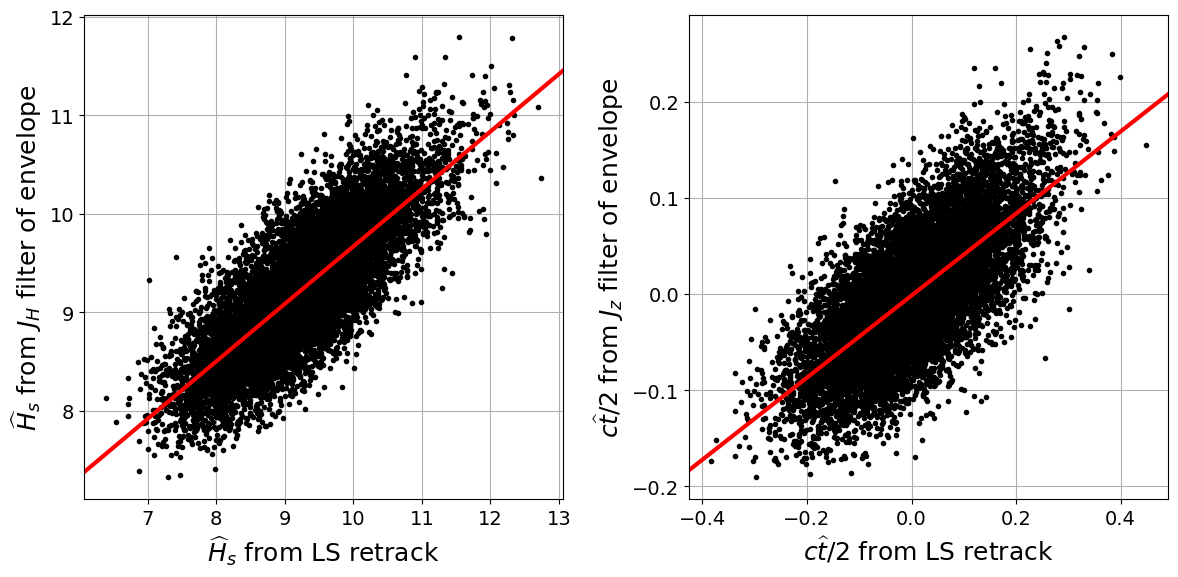

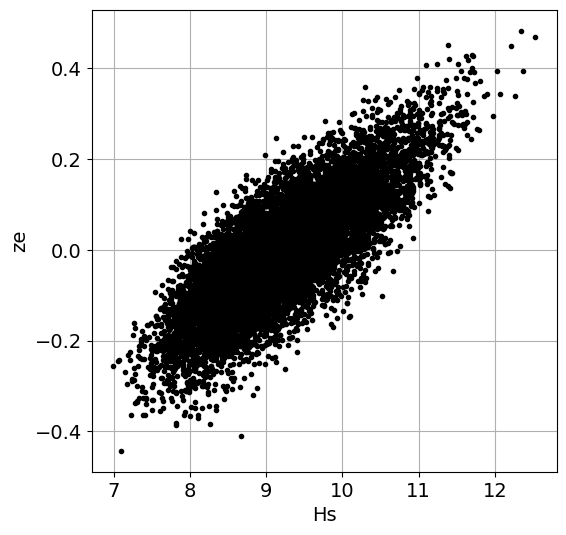

In [17]:

from scipy import stats

ratio_ze = np.abs(ze2-(equiv_ze))/np.abs(equiv_ze)

ratio_ze = (ze2+1)/(equiv_ze +1)
# plt.hist(ratio_ze.flatten(),bins=np.linspace(0,5,200));

fig,axs=plt.subplots(1,2,figsize=(12,6))
axs[0].plot(Hs2,equiv_Hs,'.k');
re=stats.pearsonr((Hs2).flatten(),equiv_Hs.flatten())
res = stats.linregress((Hs2).flatten(),equiv_Hs.flatten())
rval = res.rvalue;rinter = res.intercept;rslope = res.slope
axs[0].axline([6.8,6.8*rslope+rinter],slope=rslope,color='r',lw=3)
print(res)
print('Corr:',re) 

axs[0].set_xlabel('$\widehat{H}_s$ from LS retrack', fontsize=18)
axs[0].set_ylabel('$\widehat{H}_s$ from $J_H$ filter of envelope', fontsize=18)
#ax.set_axline([0,0],slope=1,color='k',linestyle='--')


axs[1].plot(ze2,equiv_ze,'.k');
axs[1].set_xlabel('$c \widehat{t}/2$ from LS retrack', fontsize=18)
axs[1].set_ylabel('$c \widehat{t}/2$ from $J_z$ filter of envelope', fontsize=18)
#ax.set_axline([0,0],slope=1,color='k',linestyle='--')
# plt.axline([0,0],slope=2,color='r')
# plt.axline([0,0],slope=1.5,color='b')
re=stats.pearsonr((ze2).flatten(),equiv_ze.flatten())
print('Corr:',re) 
res = stats.linregress((ze2).flatten(),equiv_ze.flatten())
rval = res.rvalue;rinter = res.intercept;rslope = res.slope
axs[1].axline([0,rinter],slope=rslope,color='r',lw=3)
print(res)
plt.tight_layout()
fig.savefig('corr_Hs_JH_ze_Jz.pdf')



fig,ax=plt.subplots(figsize=(6,6))
ax.plot(Hs1,ze1,'.k');
ax.set_xlabel('Hs')
ax.set_ylabel('ze')
#ax.set_axline([0,0],slope=1,color='k',linestyle='--')
# plt.axline([0,0],slope=2,color='r')
# plt.axline([0,0],slope=1.5,color='b')
res = stats.linregress((ze1).flatten(),Hs1.flatten())
print(res)
res = stats.linregress((ze2).flatten(),Hs2.flatten())
print(res)

In [18]:
print(np.shape(Hs1),Xa[iasamp[0]],Xa[iasamp[1]],Xalt[0],Xalt[1],106*105)

(106, 105) 9995.999999997865 10345.99999999779 9995.999999997865 10345.99999999779 11130


## Compare Hs1 and Hs2

0.7950976989283594 0.8738102253906808 9.195848077901049 9.232693535349362
9.230157215490838 9.273951381567581
0.5899907702815896 1.940672860674252 9.212503773804258 9.203085814198893
9.231376652015406 9.405477109411647
9.195848077901049 9.232693535349362 <module 'numpy' from '/home/ardhuin/.local/lib/python3.10/site-packages/numpy/__init__.py'>


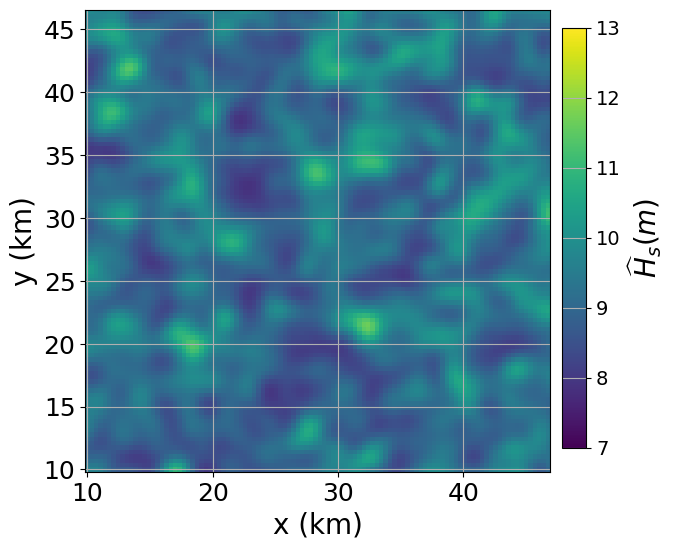

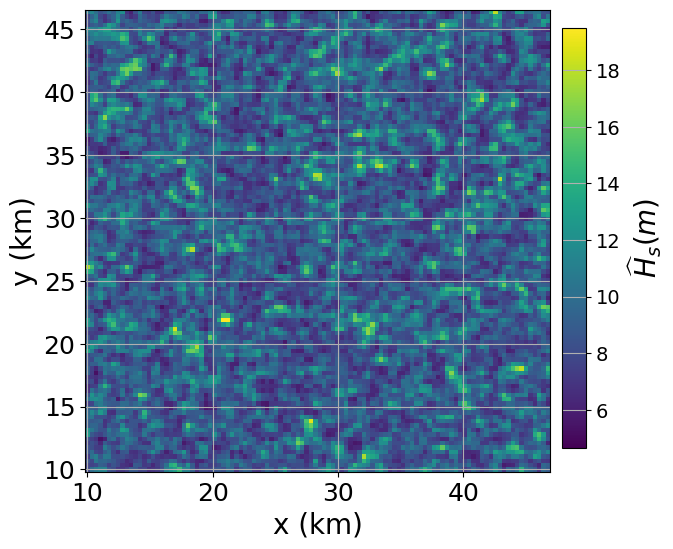

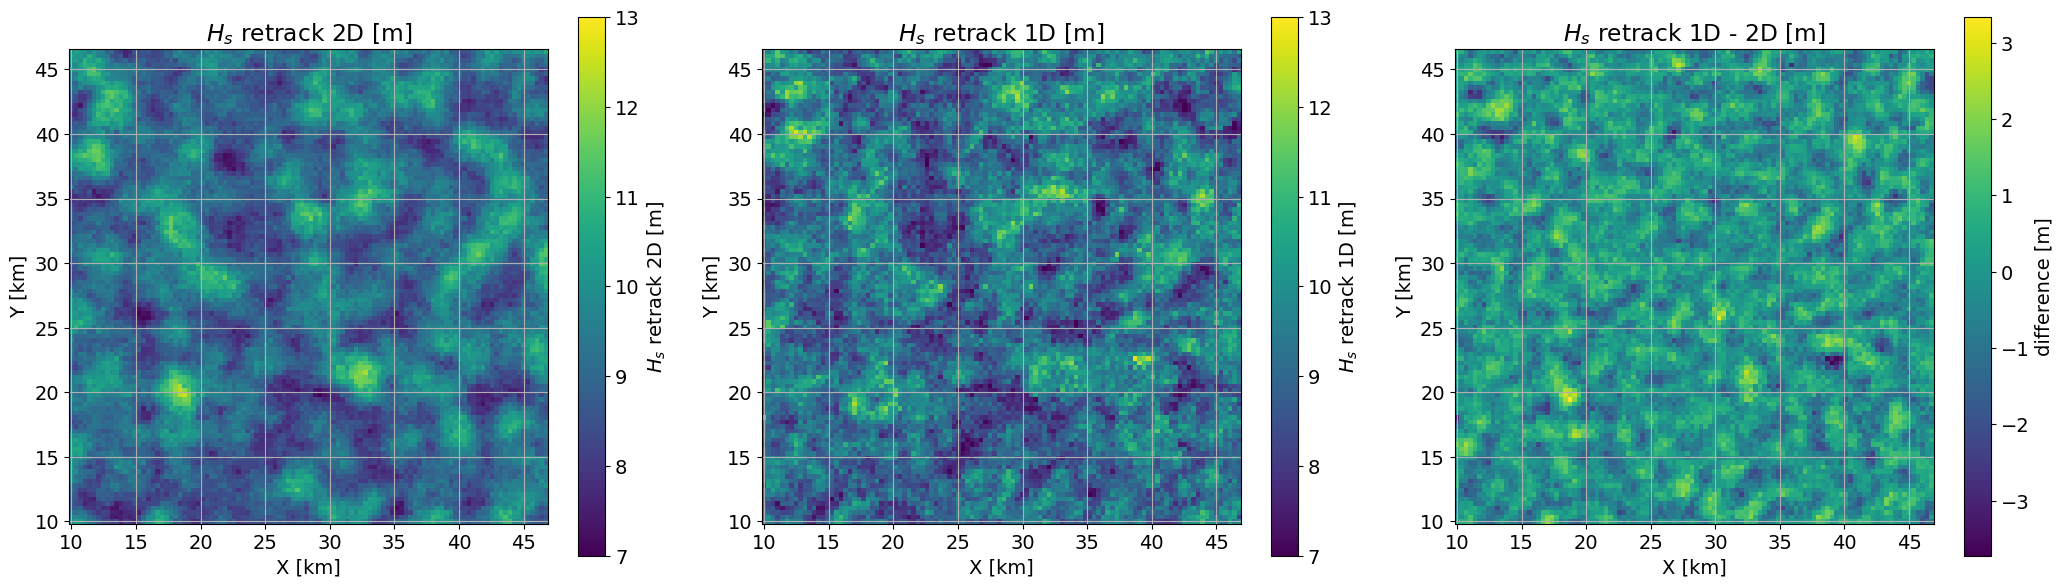

In [19]:
Hmin=7
Hmax=13
print(np.std(Hs1),np.std(Hs2),np.mean(Hs1),np.mean(Hs2))
print(np.sqrt(np.mean(Hs1*Hs1)),np.sqrt(np.mean(Hs2*Hs2)))
print(np.std(B22),np.std(B42),np.mean(B22),np.mean(B42))
print(np.sqrt(np.mean(B22*B22)),np.sqrt(np.mean(B42*B42)))

print(np.mean(Hs1),np.mean(Hs2),np)

fig,ax=plt.subplots(figsize=(6,6))
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,B22.T ,vmin=Hmin, vmax=Hmax,rasterized=True)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label(r'$\widehat{H}_s (m)$', fontsize=20)
#ticklabs = cbar.ax.get_yticklabels()
#cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig.savefig('Hs_G1_filt.pdf')
fig.savefig('Hs_G1_filt.png')

fig,ax=plt.subplots(figsize=(6,6))
#im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs2.T,vmin=4, vmax=14)
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,B42.T,vmin=Hmin/1.5, vmax=Hmax*1.5,rasterized=True)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label(r'$\widehat{H}_s (m)$', fontsize=20)
#ticklabs = cbar.ax.get_yticklabels()
#cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig.savefig('Hs_G2_filt.pdf')
fig.savefig('Hs_G2_filt.png')


fig,axs=plt.subplots(1,3,figsize=(21,6))

ax=axs[0]
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs1.T,vmin=Hmin,vmax=Hmax)
ax=custom_plots_surf(ax,im,iskm=1,alongT_isY=0,labelcb='$H_s$ retrack 2D [m]')
[vmin,vmax]=im.get_clim()
ax.set_title('$H_s$ retrack 2D [m]')

ax=axs[1]
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs2.T,vmin=Hmin,vmax=Hmax)
ax=custom_plots_surf(ax,im,iskm=1,alongT_isY=0,labelcb='$H_s$ retrack 1D [m]')
ax.set_title('$H_s$ retrack 1D [m]')

ax=axs[2]
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,(Hs1-Hs2).T)#,vmin=vmin,vmax=vmax)
ax=custom_plots_surf(ax,im,iskm=1,alongT_isY=0,labelcb='difference [m]')
ax.set_title('$H_s$ retrack 1D - 2D [m]')

plt.tight_layout()

TEST: 14 14 350


(np.float64(-1.4560439560439562),
 np.float64(1.4010989010989008),
 np.float64(-1.4285714285714286),
 np.float64(1.4285714285714286))

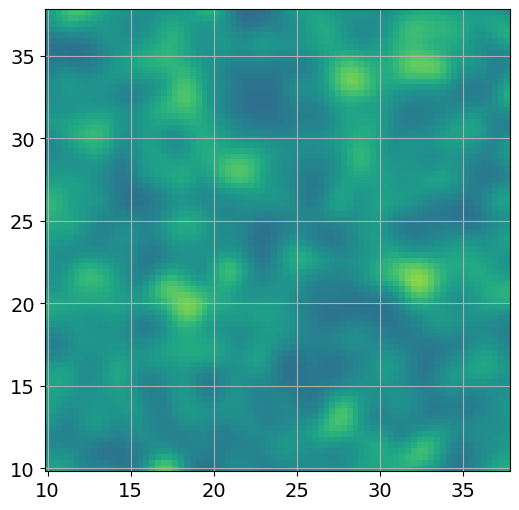

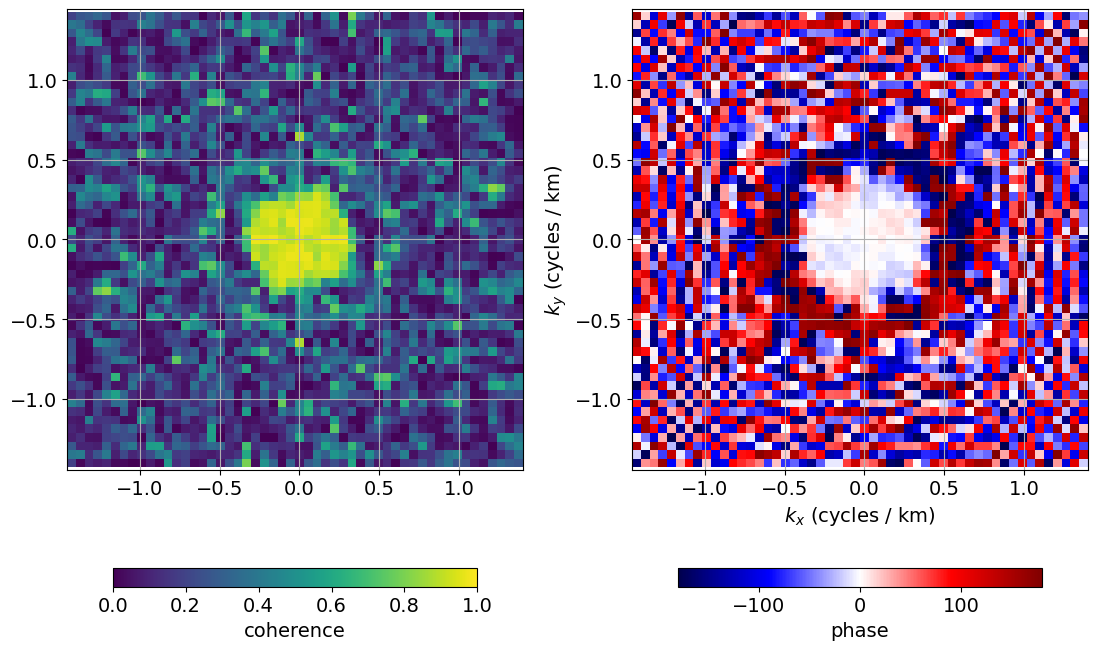

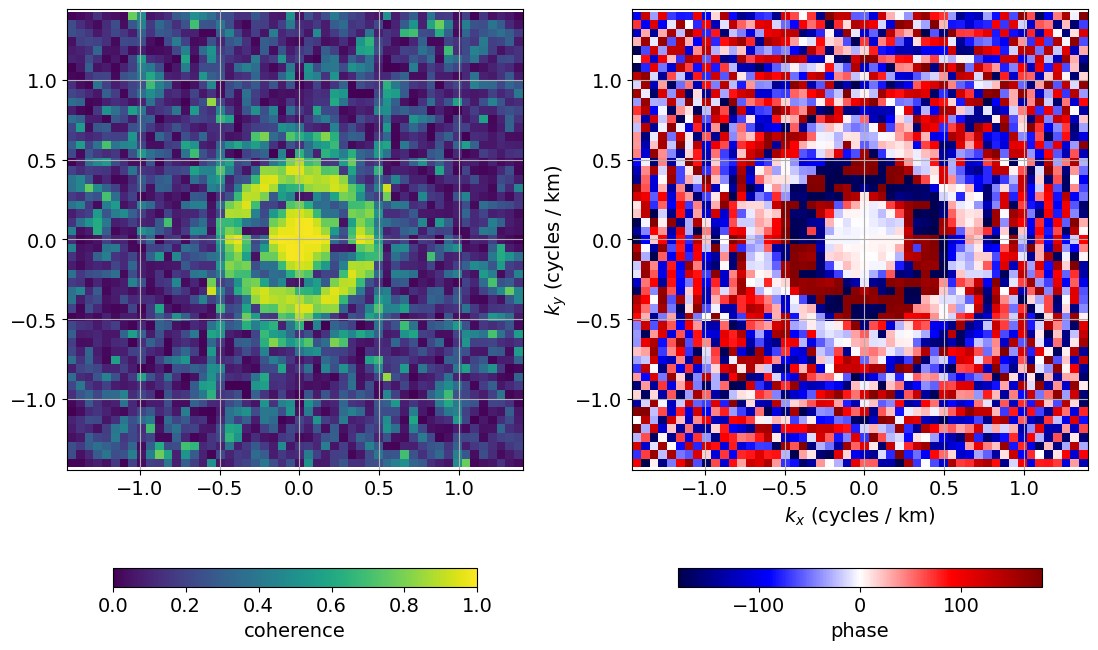

In [31]:
Hmin=5
Hmax=13
from  spectral_analysis_functions import FFT2D_two_arrays

fig,ax=plt.subplots(figsize=(6,6))
vmin=None
vmax=None
im=ax.pcolormesh(Xalt[0:80]/1e3,Yalt[0:80]/1e3,B22[0:80,0:80].T ,vmin=Hmin, vmax=Hmax,rasterized=True)

(Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays(B22,Hs1,dy*di,dx*di,2,isplot=0)


fshrink=0.8;fig,axs=plt.subplots(1,2,figsize=(11.2,7))#,sharey=True,sharex=True)
im=axs[0].pcolormesh((ky2-dky*0.0)*1000,(kx2-dkx*0.0)*1000,coh,cmap='viridis',rasterized=True,vmin = 0, vmax =1)
_=plt.colorbar(im,ax=axs[0],label='coherence', location='bottom',shrink=fshrink)
_=axs[1].set_xlabel('$k_x$ (cycles / km)')
_=axs[1].set_ylabel('$k_y$ (cycles / km)')
axs[0].axis('equal')
#axs[0].set_ylim((X[i1],X[i2]))
#axs[0].set_xlim((Y[j1],Y[j2]))

im=axs[1].pcolormesh((ky2-dky*0.0)*1000,(kx2-dkx*0.0)*1000,np.degrees(ang),cmap='seismic',rasterized=True,norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='phase', location='bottom',shrink=fshrink)
_=axs[1].set_xlabel('$k_x$ (cycles / km)')
_=plt.tight_layout()
axs[0].axis('equal')
axs[1].axis('equal')


(Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays(B22,Hs2,dy*di,dx*di,2,isplot=0)


fshrink=0.8;fig,axs=plt.subplots(1,2,figsize=(11.2,7))#,sharey=True,sharex=True)
im=axs[0].pcolormesh((ky2-dky*0.0)*1000,(kx2-dkx*0.0)*1000,coh,cmap='viridis',rasterized=True,vmin = 0, vmax =1)
_=plt.colorbar(im,ax=axs[0],label='coherence', location='bottom',shrink=fshrink)
_=axs[1].set_xlabel('$k_x$ (cycles / km)')
_=axs[1].set_ylabel('$k_y$ (cycles / km)')
axs[0].axis('equal')
#axs[0].set_ylim((X[i1],X[i2]))
#axs[0].set_xlim((Y[j1],Y[j2]))

im=axs[1].pcolormesh((ky2-dky*0.0)*1000,(kx2-dkx*0.0)*1000,np.degrees(ang),cmap='seismic',rasterized=True,norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='phase', location='bottom',shrink=fshrink)
_=axs[1].set_xlabel('$k_x$ (cycles / km)')
_=plt.tight_layout()
axs[0].axis('equal')
axs[1].axis('equal')


## Compare 2D vs equivalent

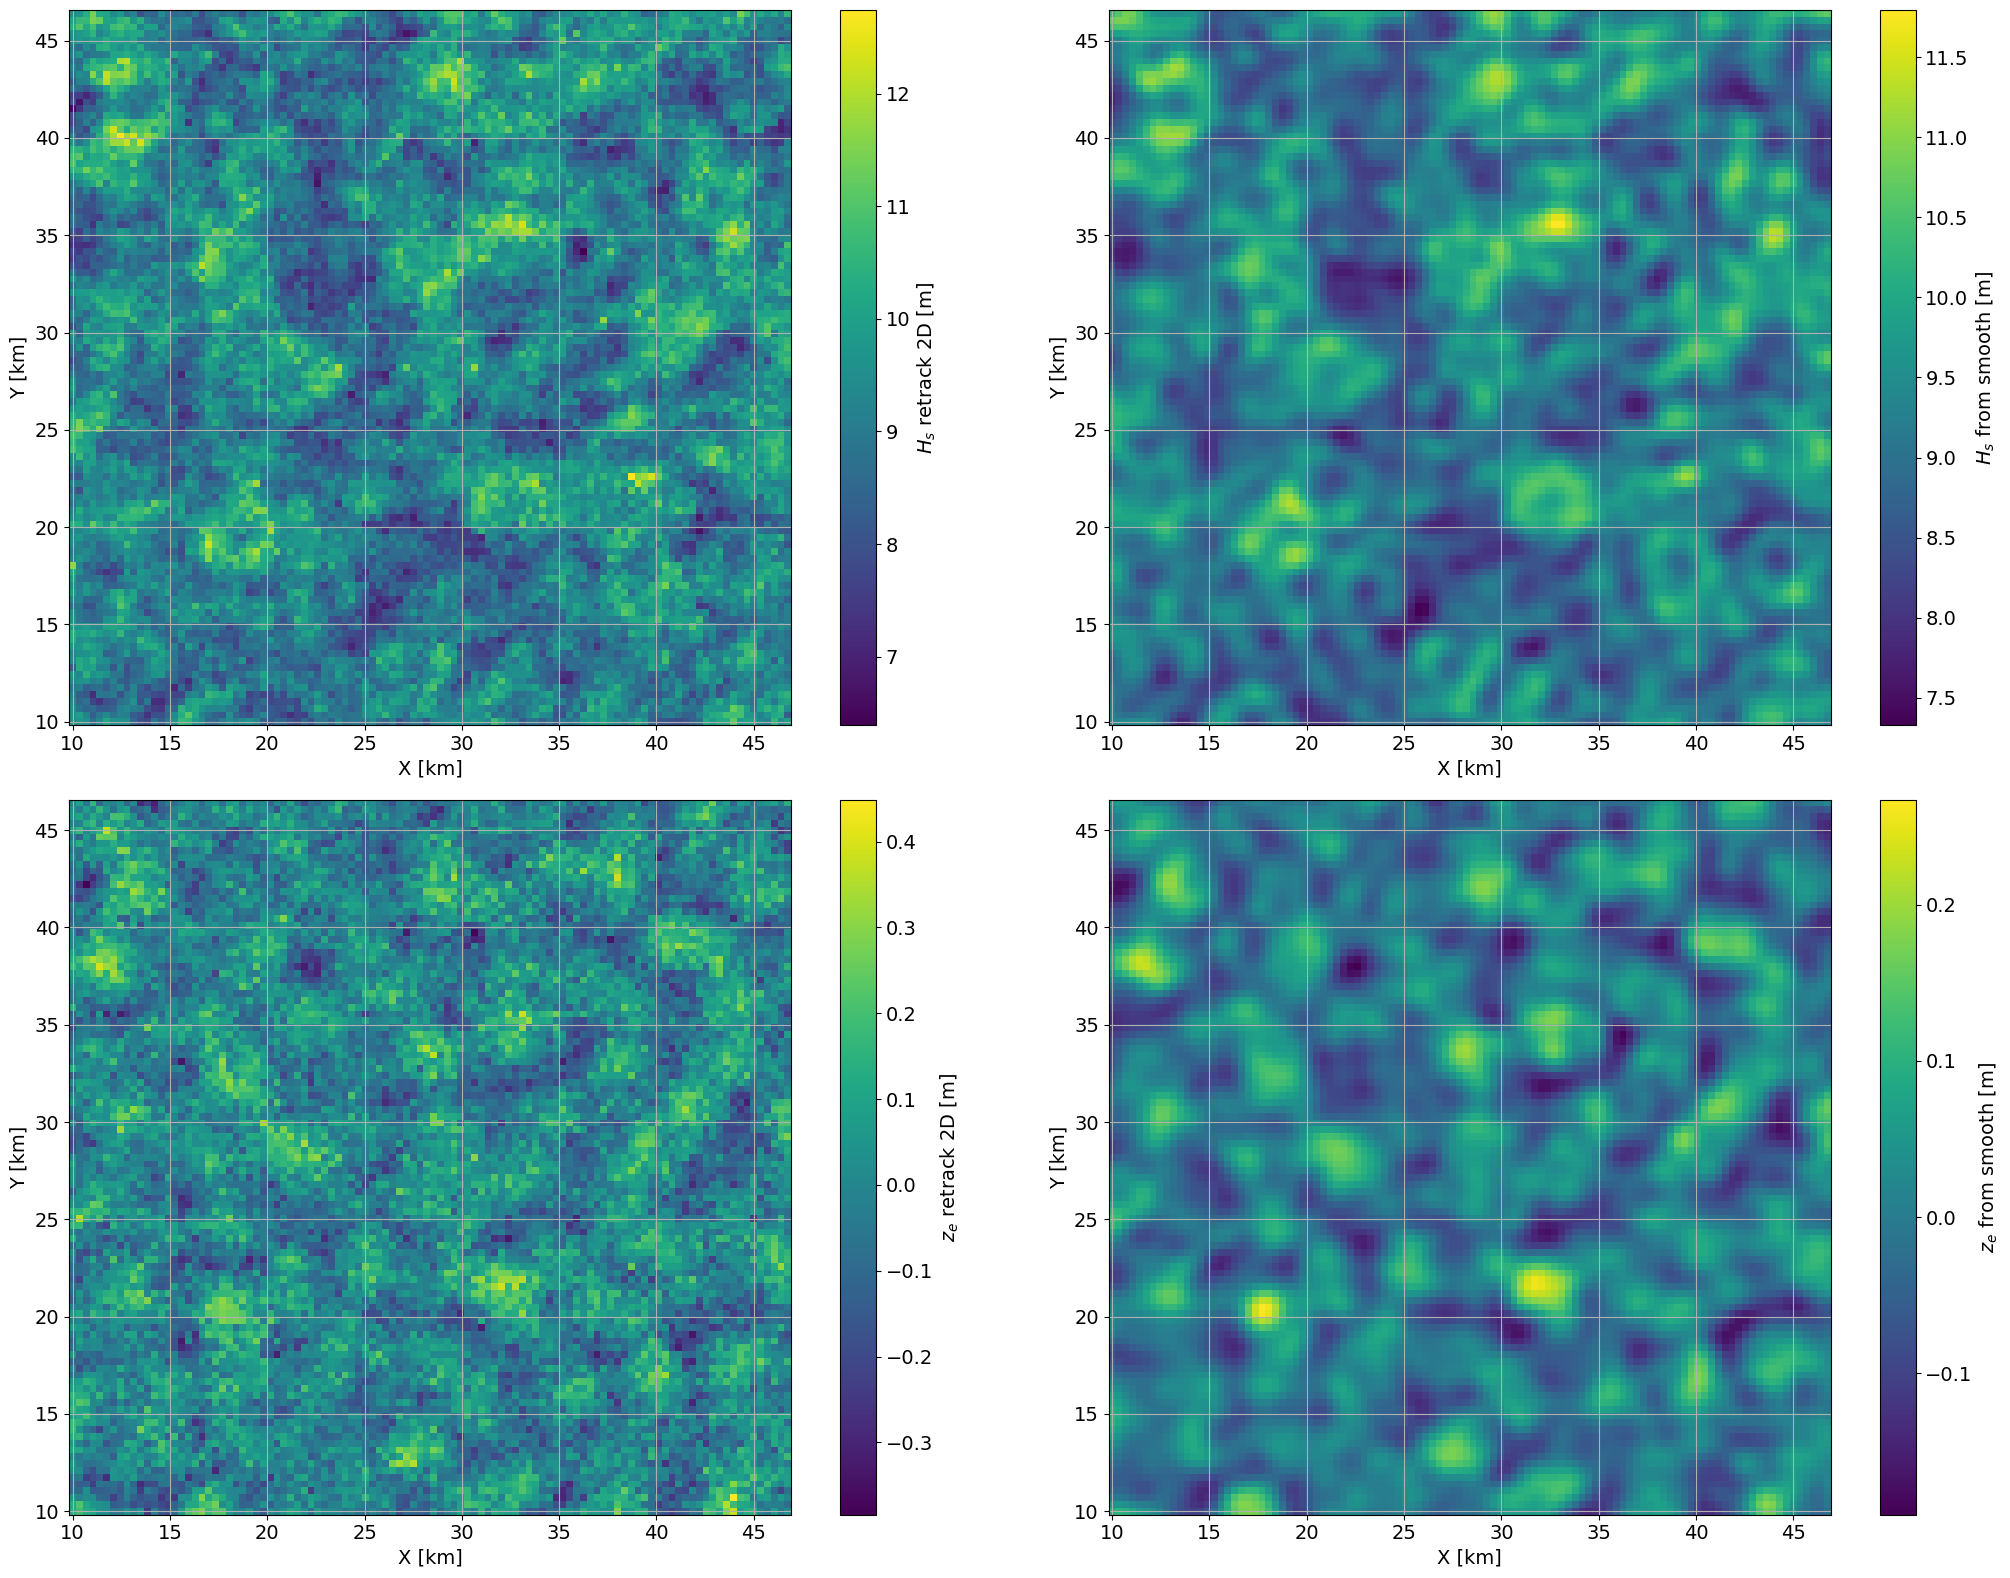

In [32]:
fig,axs=plt.subplots(2,2,figsize=(21,16))
vmin=None
vmax=None
ax=axs[0,0]
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,Hs2.T,vmin=vmin,vmax=vmax)
ax=custom_plots_surf(ax,im,iskm=1,alongT_isY=0,labelcb='$H_s$ retrack 2D [m]')
[vmin,vmax]=im.get_clim()

ax=axs[0,1]
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,equiv_Hs.T) #,vmin=vmin,vmax=vmax)
ax=custom_plots_surf(ax,im,iskm=1,alongT_isY=0,labelcb='$H_s$ from smooth [m]')

ax=axs[1,0]
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,ze2.T)
ax=custom_plots_surf(ax,im,iskm=1,alongT_isY=0,labelcb='$z_e$ retrack 2D [m]')
[vmin,vmax]=im.get_clim()

ax=axs[1,1]
im=ax.pcolormesh(Xalt/1e3,Yalt/1e3,equiv_ze.T) #,vmin=vmin,vmax=vmax)
ax=custom_plots_surf(ax,im,iskm=1,alongT_isY=0,labelcb='$z_e$ from smooth [m]')

plt.tight_layout()

LinregressResult(slope=np.float64(1.006798475395134), intercept=np.float64(-0.05091737581914124), rvalue=np.float64(0.9274506739467383), pvalue=np.float64(0.0), stderr=np.float64(0.00507502209954031), intercept_stderr=np.float64(0.046704699508152696))
LinregressResult(slope=np.float64(0.7233266446682792), intercept=np.float64(2.5619387361709913), rvalue=np.float64(0.8375904373878256), pvalue=np.float64(0.0), stderr=np.float64(0.005898081839159695), intercept_stderr=np.float64(0.054364567318609974))


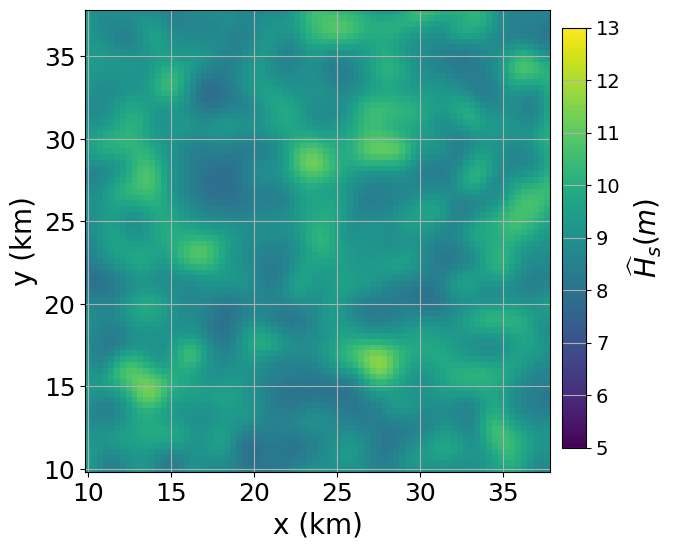

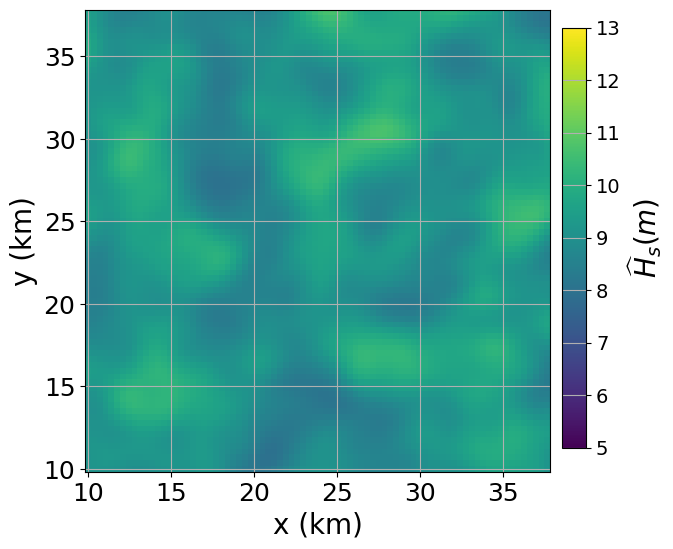

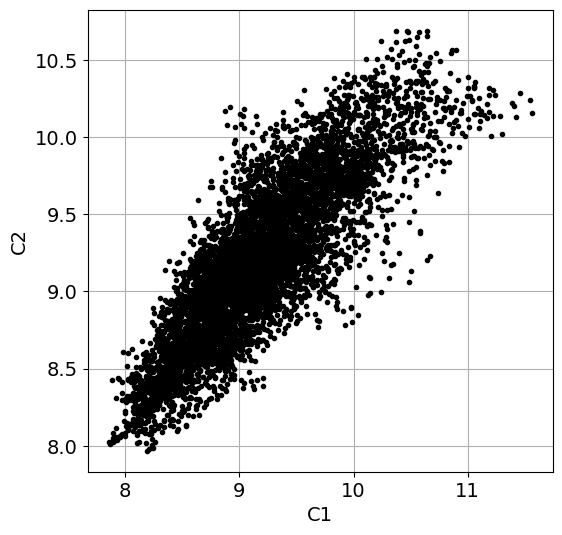

In [33]:
C1 = fftconvolve(Hs1,phi_G3,mode='same')*dx*dy*di*di
C2 = fftconvolve(B42,phi_G3,mode='same')*dx*dy*di*di
C3 = fftconvolve(Hs2,phi_G3,mode='same')*dx*dy*di*di
C4 = fftconvolve(B42,phi_G4,mode='same')*dx*dy*di*di
fig,ax=plt.subplots(figsize=(6,6))
im=ax.pcolormesh(Xalt[0:80]/1e3,Yalt[0:80]/1e3,C2[0:80,0:80].T ,rasterized=True,vmin=Hmin,vmax=Hmax)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label(r'$\widehat{H}_s (m)$', fontsize=20)
#ticklabs = cbar.ax.get_yticklabels()
#cbar.ax.set_yticklabels(ticklabs, fontsize=18)

fig,ax=plt.subplots(figsize=(6,6))
im=ax.pcolormesh(Xalt[0:80]/1e3,Yalt[0:80]/1e3,C3[0:80,0:80].T ,rasterized=True,vmin=Hmin,vmax=Hmax)
#ax.set_title('$H_s$ [m]')

ax.set_xlabel('x (km)', fontsize=20)
ax.set_ylabel('y (km)' , fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar_axim = fig.add_axes([0.92, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
cbar.set_label(r'$\widehat{H}_s (m)$', fontsize=20)
#ticklabs = cbar.ax.get_yticklabels()
#cbar.ax.set_yticklabels(ticklabs, fontsize=18)


fig,ax=plt.subplots(figsize=(6,6))
ax.plot(C2[0:80,0:80],C3[0:80,0:80],'.k');
ax.set_xlabel('C1')
ax.set_ylabel('C2')
#ax.set_axline([0,0],slope=1,color='k',linestyle='--')
# plt.axline([0,0],slope=2,color='r')
# plt.axline([0,0],slope=1.5,color='b')
res = stats.linregress((C1[0:80,0:80]).flatten(),C2[0:80,0:80].flatten())
print(res)
res = stats.linregress((C2[0:80,0:80]).flatten(),C3[0:80,0:80].flatten())
print(res)
